In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Introducción a Redes Complejas en Biología de Sistemas

## Trabajo computacional 2

### Introducción

En 2001, Jeong et al. observaron que en diversas redes de proteínas de <i>Saccharomyces cerevisiae</i> los nodos con mayor número de conexiones tienen una alta tendencia a ser <b>esenciales</b>. Una mutación que provoque la pérdida de función de estas proteínas redunda en la muerte o incapacidad reproductiva del organismo. Desde entonces, este fenómeno ha sido descripto en muchos otros seres vivos, y los esfuerzos por explicar por qué tiene lugar han sido varios. 

En una primera aproximación, el mismo Jeong postuló que los hubs (nodos de alto grado) son esenciales porque <b>mantienen la conectividad de la red</b>. He et al., por su parte, hipotetizaron en 2006 que lo verdaderamente esencial no son las entidades proteicas, sino <b>las interacciones entre ellas</b>. En este trabajo se postuló además que estas interacciones esenciales estaban uniformemente distribuidas en la red, y que así <b>la probabilidad de que dos proteínas no interconectadas sean esenciales era disjunta</b>.<br>


En 2008, Zotenko et al. refutaron esta hipótesis al demostrar que en varias redes de distinto origen y en forma consistente, la probabilidad de que una proteína sea esencial depende de la esencialidad de proteínas no vecinas con las que comparte un número elevado de vecinos en común. Surgió así la idea de que <b>la esencialidad debe ser estudiada en un nivel organizacional superior</b>, ya que <b>los nodos esenciales lo son porque su disrrupción provoca el malfuncionamiento de complejos proteicos que cumplen funciones biológicas esenciales</b>. De esta forma, la remoción individual de proteínas que no tienen conexión entre sí pero forman parte del mismo complejo puede alterar la misma función necesaria para la vida o la reproducción.

En el presente trabajo práctico se reproducirán los principales resultados y las principales conclusiones de los trabajos mencionados, utilizando cuatro redes de diverso origen descriptas en el apartado que sigue.

### Características de las redes analizadas

Se utilizaron cuatro redes de interacción proteína-proteína de <i>Saccharomyces cerevisiae</i>:
<ol>
    <li><b>AP_MS</b>: Constuída a partir de ensayos de coinmunoprecipitación. Utilizando anticuerpos específicos, se forman precipitados proteicos que se secuencian luego por espectrofotometría de masas. Las interacciones están sobreestimadas, ya que como la conectividad en cada complejo es desconocida, todas las proteínas coprecipitadas se reportan en forma de cliqué. Así, las interacciones reportadas correlacionan bien con la pertenencia a un mismo complejo proteico.
    <li><b>Y2H</b>: Ensamblada a partir de ensayos de doble híbrido, por lo que reporta interacciones pareadas reales. Su desventaja principal es que no todas las interacciones posibles fueron testeadas, por lo que tiende a subestimar las interacciones reales y a estar enrriquecida en entidades de importancia científica previa.
    <li><b>LITR</b>: Armada a partir de <i>text-mining</i> de trabajos científicos. Como la presencia consistente en publicaciones puede tener otras causas que la interacción física entre los nodos, este método tiende a sobreestimar la cantidad de interacciones.
    <li><b>LIT</b>: Similar a LITR, pero producto de un curado manual posterior.

</ol>

In [58]:
%matplotlib inline
import itertools, random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uncertainties.umath as um
from tqdm import tqdm_notebook as tqdm
from scipy import stats
from tqdm import tqdm_notebook as tqdm
from random import shuffle
from collections import defaultdict
from uncertainties import ufloat

Se utilizó la lista de 1156 proteínas esenciales provista por el paper de He et al. A continuación se muestra un <i>layout</i> de la componente gigante de cada una de las cuatro redes mencionadas, seguida de una tabla con sus principales características. Notar que, como en la red AP_MS las unidades de construcción corresponden a complejos proteicos con un alto grado de conectividad, el coeficiente de <i>clustering</i> es muy alto.

In [3]:
#Levantamos el archivo que contiene los nodos esenciales

esenciales = []
for x in list(open("./Essential_ORFs_paperHe.txt"))[2:]:
    esenciales.append(x.split()[1])
print("Cantidad de proteinas esenciales: " 
      + str(len(esenciales)))

Cantidad de proteinas esenciales: 1156


In [4]:
AP_MS_g = nx.read_gml("AP_MS.gml")
Y2H_g = nx.read_gml("Y2H.gml")
LIT_g = nx.read_gml("LIT.gml")
LITR_g = nx.read_gml("LITR.gml")

Nodos: 1622. Aristas: 9070. Esenciales: 607


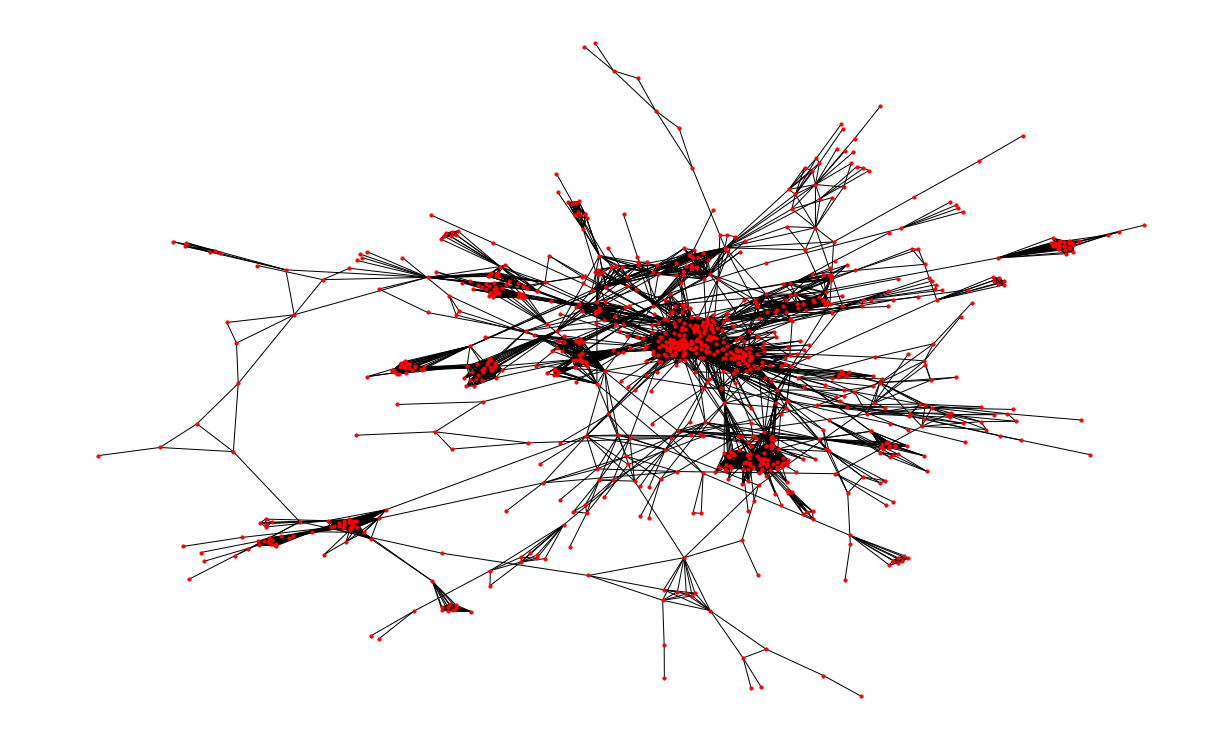

In [5]:
plt.rcParams['figure.figsize'] = (16,10)

AP_MS = nx.Graph()
for x in open("./yeast_AP-MS.txt"):
    n1,n2 = x.strip().split()
    AP_MS.add_edge(n1,n2)
print("Nodos: %i. Aristas: %i. Esenciales: %i" % 
      (len(AP_MS.nodes()),len(AP_MS.edges()),
       len(set(esenciales) & set(AP_MS.nodes()))
      ))

cc = sorted([x for x in nx.connected_components(AP_MS) ],key=len)[-1]
nx.draw(AP_MS.subgraph(cc),node_size=10)

Nodos: 2018. Aristas: 2930. Esenciales: 451


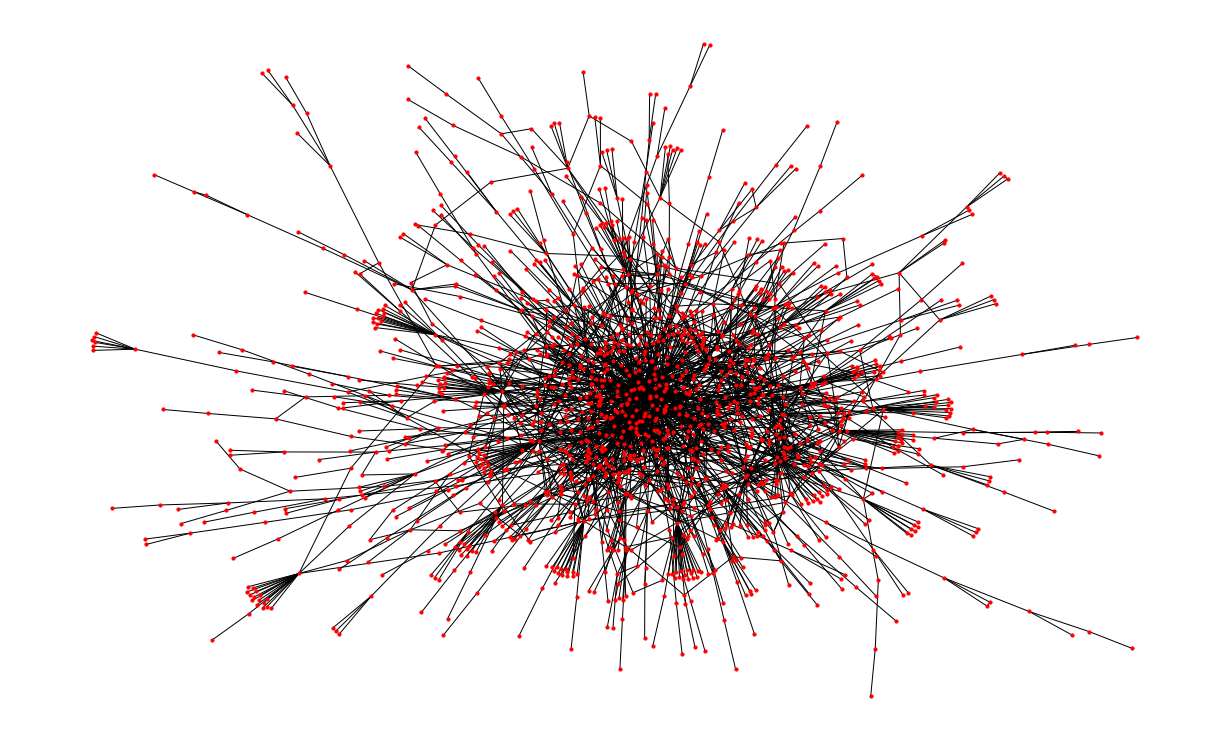

In [6]:
Y2H = nx.Graph()
for x in open("./yeast_Y2H.txt"):
    n1,n2 = x.strip().split()
    Y2H.add_edge(n1,n2)
print("Nodos: %i. Aristas: %i. Esenciales: %i" % 
      (len(Y2H.nodes()),len(Y2H.edges()),
       len(set(esenciales) & set(Y2H.nodes()))
      ))

cc = sorted([x for x in nx.connected_components(Y2H) ],key=len)[-1]
nx.draw(Y2H.subgraph(cc),node_size=10)

Nodos: 1536. Aristas: 2925. Esenciales: 625


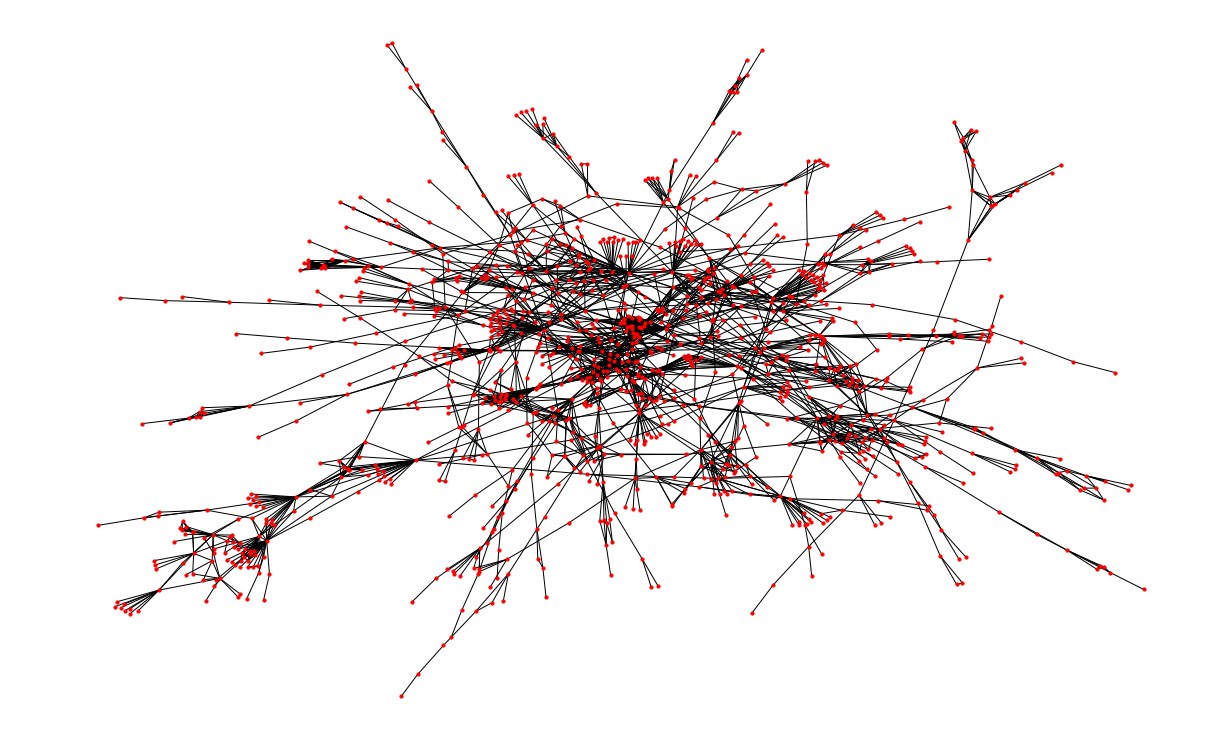

In [7]:
LIT = nx.Graph()
for x in open("./yeast_LIT.txt"):
    n1,n2 = x.strip().split()
    LIT.add_edge(n1,n2)
print("Nodos: %i. Aristas: %i. Esenciales: %i" % 
      (len(LIT.nodes()),len(LIT.edges()),
       len(set(esenciales) & set(LIT.nodes()))
      ))

cc = sorted([x for x in nx.connected_components(LIT) ],key=len)[-1]
nx.draw(LIT.subgraph(cc),node_size=10)

Nodos: 3307. Aristas: 11858. Esenciales: 896


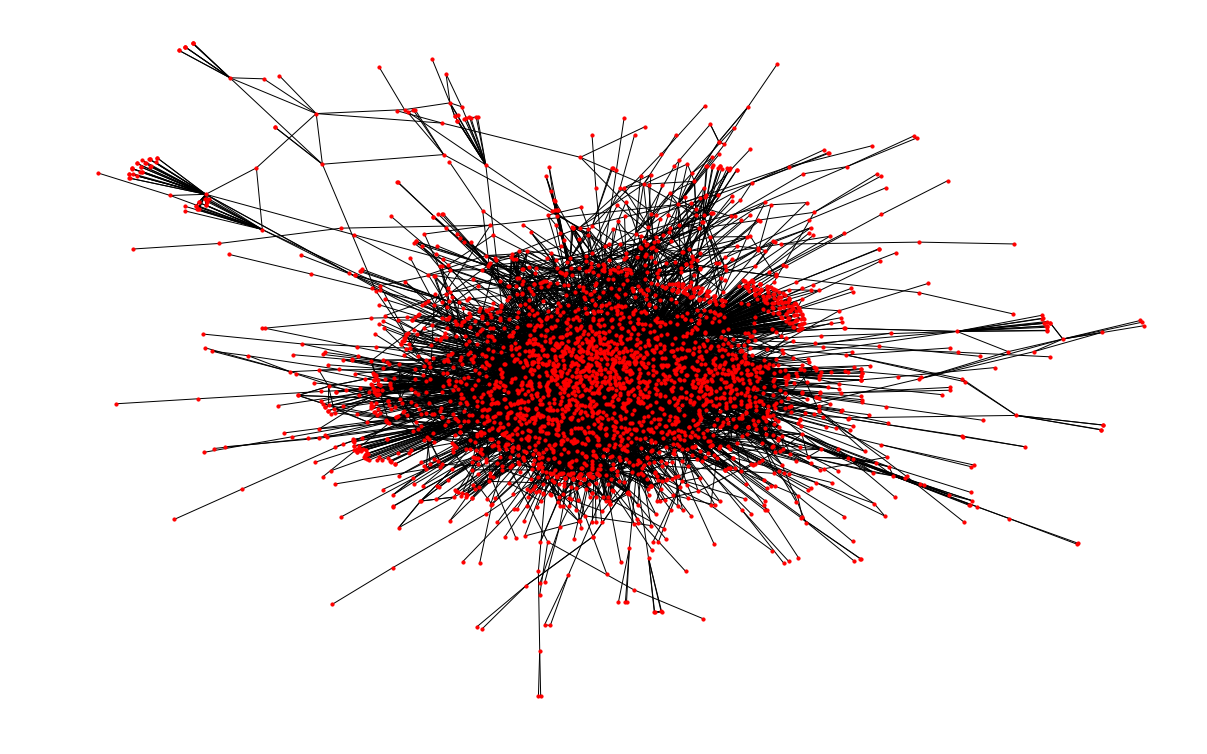

In [8]:
LITR = nx.Graph()
for x in list(open("./yeast_LIT_Reguly.txt"))[1:]:
    n1,n2 = x.strip().split()[:2]
    LITR.add_edge(n1,n2)
print("Nodos: %i. Aristas: %i. Esenciales: %i" % 
      (len(LITR.nodes()),len(LITR.edges()),
       len(set(esenciales) & set(LITR.nodes()))
      ))

cc = sorted([x for x in nx.connected_components(LITR) ],key=len)[-1]
nx.draw(LITR.subgraph(cc),node_size=10)

In [9]:
# #Guardamos los grafos en un .gml con el atributo de esencialidad incorporado

# for n,G in {"AP_MS":AP_MS,"Y2H":Y2H,"LIT":LIT,"LITR":LITR}.items():
#    esencial_dict = {x: (x in esenciales) for x in G.nodes() }
#    nx.set_node_attributes(G,  esencial_dict,'esencial')
#    nx.write_gml(G, n + ".gml")

In [8]:
lista = []
for G in [AP_MS,Y2H,LIT,LITR]:
    grafo = {}
    grafo["Nodos"] = nx.number_of_nodes(G)
    grafo["Aristas"] = nx.number_of_edges(G)    
    #grafo["Gradomin"] = min(dict(nx.degree(G)).values())
    #grafo["Gradomax"] = max(dict(nx.degree(G)).values())
    grafo["Gradomedio"] = round(np.mean(list(dict(nx.degree(G)).values())),3)
    #grafo["Density"] = round(nx.density(G),3)
    grafo["Clustering"] = nx.average_clustering(G)
    #grafo["Transitividad"] = nx.transitivity(G)
    #cc = sorted([x for x in nx.connected_components(G) ],key=len)[-1]
    #grafo["Diametro"] = nx.diameter(G.subgraph(cc))
    lista.append(grafo)

In [9]:
df = pd.DataFrame(lista, index=["AP_MS","Y2H","LIT","LITR"])
print("Tabla 1 de Zotenko et. al. (2008)")
df[["Nodos","Aristas","Gradomedio","Clustering"]]

Tabla 1 de Zotenko et. al. (2008)


,Nodos,Aristas,Gradomedio,Clustering
AP_MS,1622,9070,11.184,0.554636
Y2H,2018,2930,2.904,0.046194
LIT,1536,2925,3.809,0.292492
LITR,3307,11858,7.171,0.261134


Como las redes empleadas provienen de distinto origen y sus interacciones no representan lo mismo, se procedió a cuantificar el solapamiento de las interacciones presentes entre ellas (de todos los pares de nodos posibles para cada red, se contaron aquellos presentes en cada una de las otras).

\begin{equation*}
overlap = pe_ij  /  pe_i
\end{equation*}

donde pe_i es la cantidad de interacciones de la red i presentes en la red j, y pe_i es la cantidad total de interacciones en la red j.

In [10]:
def Overlap_matrix(Net_names, *args):
    """A partir de una lista de redes como único parámetro, genera una matriz triangular de solapamiento"""
    
    #Crea un diccionario con los nodos de cada red
    Net_dict = {}
    for name,net in zip(Net_names,args):
        Net_dict[name] = [node for node in net.nodes()]
    
    #Comparamos el overlap cada una de las claves del diccionario generado, y
    #almacenamos los datos en un dataFrame
    Overlap_df = {Name:{} for Name in Net_names}
    
    for Name1,Net1 in zip(Net_names,list(Net_dict.values())):
        for Name2,Net2 in zip(Net_names, list(Net_dict.values())):
            
            #Se obtiene el número de nodos en común entre el par de redes
            Overlap = len(np.intersect1d(Net1, Net2, assume_unique=False))
            Overlap_df[Name1][Name2] = np.round(Overlap/len(Net2),2)
            Overlap_df[Name2][Name1] = np.round(Overlap/len(Net1),2)
    
    return pd.DataFrame(Overlap_df).sort_index(axis=0).sort_index(axis=1)

Overlap_matrix(['AP_MS','Y2H','LIT','LITR'], AP_MS, Y2H, LIT, LITR)

,AP_MS,LIT,LITR,Y2H
AP_MS,1.00,0.57,0.88,0.45
LIT,0.60,1.00,0.99,0.48
LITR,0.43,0.46,1.00,0.40
Y2H,0.36,0.37,0.66,1.00


Las filas corresponden a las redes de referencia, y las columnas a las redes con las cuales se está comparando. Así, por ejemplo, el valor correspondiente al cruce entre la segunda fila y la tercera columna corresponde a la fracción de interacciones de LIT presentes además en LITR. Notar en este caso particular que como la primera es una versión revisada de la segunda, el solapamiento es casi total. El caso inverso, sin embargo (fila 3, columna 2) muestra un solapamiento drásticamente menor de tan sólo el 46%.

In [11]:
def Essential_fraction(Net):
    """Devuelve la fracción de nodos esenciales en la lista ingresada"""
    Node_list = [i for i in Net.nodes()]
    Essential = esenciales
    Intersect = np.intersect1d(Node_list, Essential, assume_unique=False)
    return len(Intersect)/len(Node_list)

In [12]:
def Hub_nodes(Net, hub_cutoff):
    """Devuelve la fracción de nodos en la lista ingresada de grado igual o más alto que el cutoff"""
    
    Grade_list = [node for node,degree in dict(Net.degree()).items() if degree >= hub_cutoff]
    return (len(Grade_list)/len(Net.nodes()),Net.subgraph(Grade_list))

Se procedió entonces a estudiar la ley de centralidad-letalidad en cada una de las redes. Para esto, se definieron como hubs aquellas proteínas que presentan un grado igual o mayor a un valor k. Para cada número de k se calcularon la fracción del total de nodos que cumplen con la definición de hubs, y la fracción de nodos esenciales pertenecientes a estos hubs.

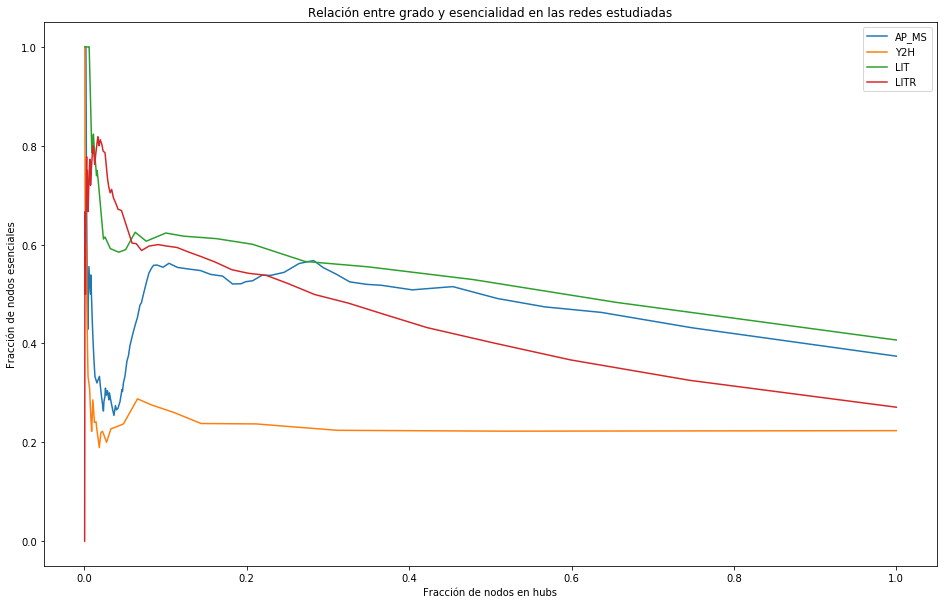

In [13]:
#Generamos un rango de cutoffs en los cuales trabajar

range_degree_AP_MS = np.array(range(0,max(list(dict(AP_MS.degree).values()))))+1
x_AP_MS = [Hub_nodes(AP_MS, i)[0] for i in range_degree_AP_MS][::-1]
y_AP_MS = [Essential_fraction(Hub_nodes(AP_MS,i)[1]) for i in range_degree_AP_MS[::-1]]
plt.plot(x_AP_MS,y_AP_MS, label='AP_MS')

range_degree_Y2H = np.array(range(0,max(list(dict(Y2H.degree).values()))))+1
x_Y2H = [Hub_nodes(Y2H, i)[0] for i in range_degree_Y2H][::-1]
y_Y2H = [Essential_fraction(Hub_nodes(Y2H,i)[1]) for i in range_degree_Y2H[::-1]]
plt.plot(x_Y2H,y_Y2H, label='Y2H')

range_degree_LIT = np.array(range(0,max(list(dict(LIT.degree).values()))))+1
x_LIT = [Hub_nodes(LIT, i)[0] for i in range_degree_LIT][::-1]
y_LIT = [Essential_fraction(Hub_nodes(LIT,i)[1]) for i in range_degree_LIT[::-1]]
plt.plot(x_LIT,y_LIT, label='LIT')

range_degree_LITR = np.array(range(0,max(list(dict(LITR.degree).values()))))+1
x_LITR = [Hub_nodes(LITR, i)[0] for i in range_degree_LITR][::-1]
y_LITR = [Essential_fraction(Hub_nodes(LITR,i)[1]) for i in range_degree_LITR[::-1]]
plt.plot(x_LITR,y_LITR, label='LITR')

plt.title('Relación entre grado y esencialidad en las redes estudiadas')
plt.xlabel('Fracción de nodos en hubs')
plt.ylabel('Fracción de nodos esenciales')

plt.legend()
plt.show()

Así, valores del eje x cercanos a cero corresponden a una baja fracción de hubs y por ende a un valor de k alto. Se observa que los nodos de grado alto (izquierda del gráfico) corresponden en gran proporción a proteínas esenciales. La tendencia se observa para las cuatro redes, aunque es claramente más débil en Y2H. En el marco que presentan Zotenco et al, esto podría tener que ver con que, como en esta red las interacciones corresponden a contactos físicos reales las interacciones dentro de cada complejo son muchas menos y el grado de las proteínas esenciales tiende al ser más bajo.

### Análisis de vulnerabilidad

Los índices de centralidad asignan valores a los nodos de la red, como forma de cuantificar características topológicas. En este análisis trabajaremos con dos tipos de índices de centralidad distintos. El primero corresponde a índices de centralidad local, donde el valor de centralidad está directamente relacionado con el grado de los nodos. El segundo hace referencia a la importancia del nodo en mantener la conectividad entre pares de nodos de la red, índice conocido como betweenness.

Para estudiar el papel de los hubs en las redes de interacción  de proteínas estudiadas se compararon índices de centralidad local (degree centrality, eigenvector  centrality y subgraph  centrality), con indices de betweenness (shortest-path betweenness centrality (SPBC) y current-flow betweenness   centrality   (CFC)).

Así se comparó cuan vulnerables son las redes al desarmar por los distintos criterios, midiendo el tamaño de su componente principal al ir removiendo los nodos por valor de centralidad decreciente.

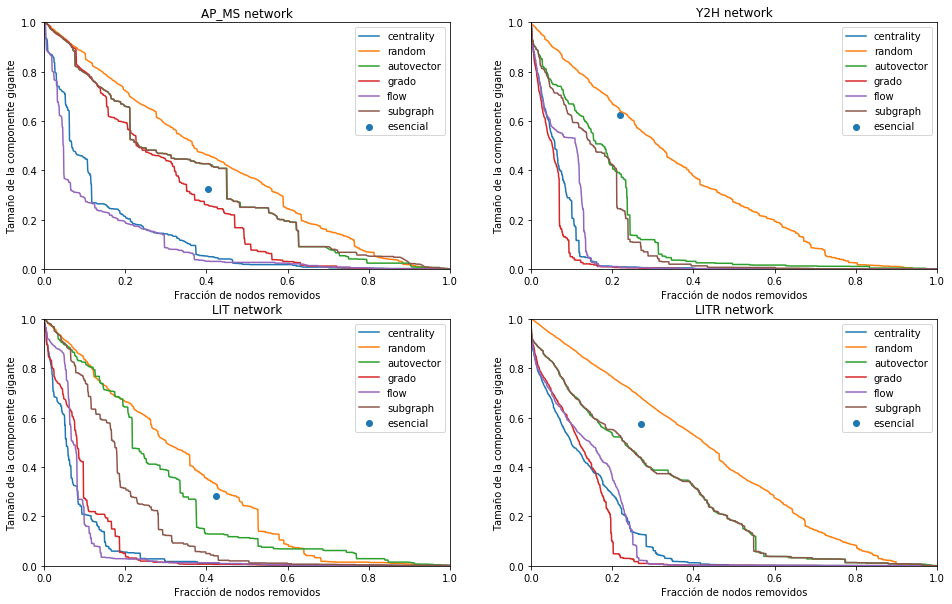

In [14]:
def Plot_cc(grafo, t):
    """Desarma la red ingresada con las métricas mencionadas y grafica el tamaño de la componente gigante en función
    del número de nodos removidos"""

    Gcc = sorted([x for x in nx.connected_components(grafo) ],key=len)[-1]
    size_cc = len(Gcc)
    Gcc = grafo.subgraph(Gcc)

    be = [k for k,v in sorted(nx.betweenness_centrality(Gcc).items(),key=lambda x:x[1],reverse=True)]
    grado_dist =[k for k,v in sorted( list(Gcc.degree()),key=lambda x:x[1],reverse=True)]
    random =  list(Gcc.nodes())

    G_no_es=Gcc.copy()

    nodos_quitado=0
    for e in esenciales:
        if e in G_no_es:
            G_no_es.remove_node(e)
            nodos_quitado+=1

    frac_comp=len(sorted([x for x in nx.connected_components(G_no_es) ],key=len)[-1])/size_cc

    frac_nodos=nodos_quitado/size_cc

    autovector = [k for k,v in sorted(nx.eigenvector_centrality(Gcc).items(),key=lambda x:x[1],reverse=True)]

    flow = [k for k,v in sorted(nx.current_flow_betweenness_centrality(Gcc).items(),key=lambda x:x[1],reverse=True)]

    subgraph = [k for k,v in sorted(nx.subgraph_centrality(Gcc).items(),key=lambda x:x[1],reverse=True)]

    nodos = {"centrality":be,"random":random,"autovector":autovector,"grado":grado_dist,"flow":flow,"subgraph":subgraph}

    data = {"centrality":[],"random":[],"autovector":[],"grado":[],"flow":[],"subgraph":[]}

    for criterio,lista_de_nodos in nodos.items():
        Gdesarmar = Gcc.copy()
        for x in lista_de_nodos:    
            cc = sorted([x for x in nx.connected_components(Gdesarmar) ],key=len)[-1]
            Gdesarmar.remove_node(x)
            data[criterio].append(len(cc))    
        plt.plot(np.array(range(len(data[criterio]))) / len(data[criterio]), 
                 np.array(data[criterio]) / size_cc,
                 label=criterio)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.scatter([frac_nodos],[frac_comp], label='esencial')
    plt.title(t+" network")
    plt.xlabel("Fracción de nodos removidos")
    plt.ylabel("Tamaño de la componente gigante")
    plt.legend()

#Graficamos una figura con el desarmado de las cuatro redes
plt.subplot(221)
Plot_cc(AP_MS, 'AP_MS')

plt.subplot(222)
Plot_cc(Y2H, 'Y2H')

plt.subplot(223)
Plot_cc(LIT,'LIT')

plt.subplot(224)
Plot_cc(LITR,'LITR')

plt.show()

Como era de esperar, las redes son más vulnerables al desarmado por índices de betweenness que a los índices de centralidad local, con excepción del índice de grado para las redes Y2H, LIT y LITR que las disrumpe de manera similar a los índices de betweenness. Esto podria deberse a que, como AP_MS esta más fuertemente conectada (mayor grado promedio) aunque se quiten los hubs, la componente esta conectada por varios caminos alternativos. Por otro lado, en las otras 3 redes, los hubs estan exhibiendo un elevado betweenness, por lo que los caminos importantes se dan a través de ellos (no hay tantos caminos alternativos). 

Además, se observa que todos los índices son más eficientes a la hora de desarmar las redes que el criterio de desarmado por nodos random. También se graficó el tamaño de la componente principal de las redes al remover todos los nodos esenciales y se observa que siempre los criterios de betweenness son más eficientes para desmontar las redes a esa fracción de nodos dados o que la fracción de nodos requerida para lograr dicho tamaño de la componente es mucho menor para los índices de betweenness. En conclusión, los nodos esenciales no tienen por qué ser nodos importantes para la conectividad global de las redes.

In [10]:
def quitar_no_esenciales(grafo):
    Gcc = sorted([x for x in nx.connected_components(grafo) ],key=len)[-1]
    size_cc = len(Gcc)
    Gcc = grafo.subgraph(Gcc)
    esenciales = []
    for x in list(open("./Essential_ORFs_paperHe.txt"))[2:]:
        esenciales.append(x.split()[1])
    
    G_no_es=Gcc.copy()

    nodos_quitado=0
    for e in esenciales:
        if e in G_no_es:
            G_no_es.remove_node(e)
            nodos_quitado+=1

    frac_comp=len(sorted([x for x in nx.connected_components(G_no_es) ],key=len)[-1])/size_cc
    
    
    grados = [grado for node,grado in Gcc.degree() if node in esenciales]

    no_esenciales = defaultdict(lambda:[])
    for node,grado in Gcc.degree():
        if node not in esenciales:
            no_esenciales[grado].append(node)        

    dato = []
    for i in tqdm(range(1000)):
        Gdesarmar = Gcc.copy()
        sacamos = []
        for grado in grados:        

            lista_a_sacar = list(set(no_esenciales[grado]) - set(sacamos))
            i = 1
            while not lista_a_sacar:
                lista_a_sacar = list(set(no_esenciales[grado-i]) - set(sacamos))
                i += 1
                
            
            if lista_a_sacar:
                shuffle(lista_a_sacar)
                nodo_a_sacar =  lista_a_sacar[0]        
                Gdesarmar.remove_node(nodo_a_sacar)
                sacamos.append(nodo_a_sacar)
        cc = sorted([x for x in nx.connected_components(Gdesarmar) ],key=len)[-1]
        dato.append(len(cc))
        
    return frac_comp, np.mean(dato)/size_cc, np.std(dato)/size_cc

Table_essential = pd.DataFrame({'AP_MS':quitar_no_esenciales(AP_MS),
                                'Y2H':quitar_no_esenciales(Y2H),
                                'LIT':quitar_no_esenciales(LIT),
                                'LITR':quitar_no_esenciales(LITR)})

Teniendo en cuenta lo anteriormente dicho se analizó si los hubs o nodos esenciales  suelen ser más disruptivos para las redes que nodos del mismo grado que no son esenciales. Para esto se comparó el tamaño de la componente principal de las redes al remover todos los nodos esenciales con el tamaño de la componente principal de las redes al remover la misma cantidad de nodos no esenciales pero respetando la distribución de grado.Estos resultados se observan en la siguiente tabla.

In [23]:
Table_essential_t = Table_essential.transpose()
Table_essential_t['P-valor'] = Table_essential_t.apply(lambda row: stats.norm.sf(abs(row[0]-row[1])/row[2]),axis=1)
Table_essential_t.columns = ["Essential", "Random nonesential mean", "Random nonesential sd", "P-valor"]
Table_essential_t

,Essential,Random nonesential mean,Random nonesential sd,P-valor
AP_MS,0.323705,0.421643,0.013821,6.883373e-13
Y2H,0.624165,0.625025,0.011724,4.707709e-01
LIT,0.281121,0.414303,0.003506,0.000000e+00
LITR,0.575062,0.581789,0.003850,4.031312e-02


Tanto Y2H como LITR valores muy similares de fracción de componente principal para las dos formas de desarmado. Lo que daría la pauta de que los nodos esenciales no nos más importantes que los no esenciales a la hora de mantener la conectividad global de las redes. Sin embargo, el las otras dos redes (AP_MS y LIT) pareciera ser más disruptivo desarmar por nodos esenciales que por no esenciales respetando las distribuciones de grado. Creemos que este fenómeno podría deberse a un error sistemático que se da cuando hay más nodos esenciales de un dado grado que no esenciales (fenómeno que ocurre sobre todo con los grados más elevados) y que por default al desarmar la red por nodos no esenciales se toman nodos de menor grado (en nuestra implementación). Con lo cual resulta razonable que la disrupción en dichas redes sea menor.

### Esencialidad: Módulos biológicos vs. Interacciones Esenciales

Como se explicó en la introducción, Zotenko et al cuestiona la validez de la hipótesis sobre la importancia de las interacciones esenciales de He. A continuacion se estimaran los parámetros de He y se compararan con la metodología de Zotenko, que intenta cambiar el foco de esencialidad de las inteacciones a los complejos protéicos. Es preciso norar que He et al. aclaran que su modelo puede no funcionar bien en redes en las que las interacciones no representen contactos físicos reales, como es el caso de AP_MS. En este trabajo práctico se incluyó a esta red en el análisis de todos modos, a fin de reportar posibles anormalidades en los resultados.

Los parámetros de He, alfa y beta, representan la probabilidad de que un enlace sea esencial y que una proteina sea esencial independientemente de la topología, respectivamente.
Entonces la probabilidad de que un nodo sea esencial es:

\begin{equation*}
Pe = 1 - (1 - \alpha)^k . (1 - \beta)
\end{equation*}

#### Cálculo de alfa y beta por regresión lineal

Linealizando la expresión en cuestión, pueden estimarse alpha y beta a partir de los valores obsevados mediante una regresión lineal:

\begin{equation*}
ln(1 - Pe) = k.ln(1-\alpha) + ln(1 -\beta)
\end{equation*}

Donde k es el grado de un nodo y Pe es la proporción de nodos esenciales de ese grado.
Se pone un corte en grado 10 (al igual que en He. et al) ya que para mayores grados no se tiene suficiente cantidad de nodos para obtener una proporción confiable. Por ejemplo los valores empiezan a saltar a 1 o a 0.

In [26]:
def essential_fraction_by_k(Net, esenciales):
    """Calcula la fracción de nodos no esenciales para la distribución de grado de la red ingresada"""
    Degree_dist = dict(nx.degree(Net))
    
    #Generamos un diccionario con los grados como claves y los nombres de los nodos como valores. 
    K_dict = {}
    for k,v in Degree_dist.items():
        try:
            K_dict[v].append(k)
        except KeyError:
            K_dict[v] = [k]
    
    #Generamos por último un diccionario con la fracción de nodos no esenciales por grado k
    Non_essential_dict = {k:len([i for i in v if i not in esenciales])/len(v) for k,v in K_dict.items()}
    
    return {k:v for k,v in Non_essential_dict.items() if k<10}

In [27]:
def alfa_beta(Net, esenciales):
    """Calcula alfa y beta según He et al (PLOS, 2006) a partir de regresión lineal"""
    
    NE_dict = essential_fraction_by_k(Net, esenciales)
    
    #Realizamos un ajuste lineal según la ecuación descripta en el texto
    x = np.array(list(NE_dict.keys()))
    y = np.log(np.array(list(NE_dict.values())))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    slope = ufloat(slope,std_err)
    intercept = ufloat(intercept,np.abs(intercept/10))

    #Devolvemos alfa y beta
    return (1-um.exp(slope)), (1-um.exp(intercept))

def alfa_beta_sim(Net, raw_m, m, b):
    """Calcula alfa y beta según He et al (PLOS, 2006) a partir de datos simulados"""
    alfa = (raw_m - m) / len(AP_MS.edges())
    beta = b / len(Net.nodes())
    return alfa, beta

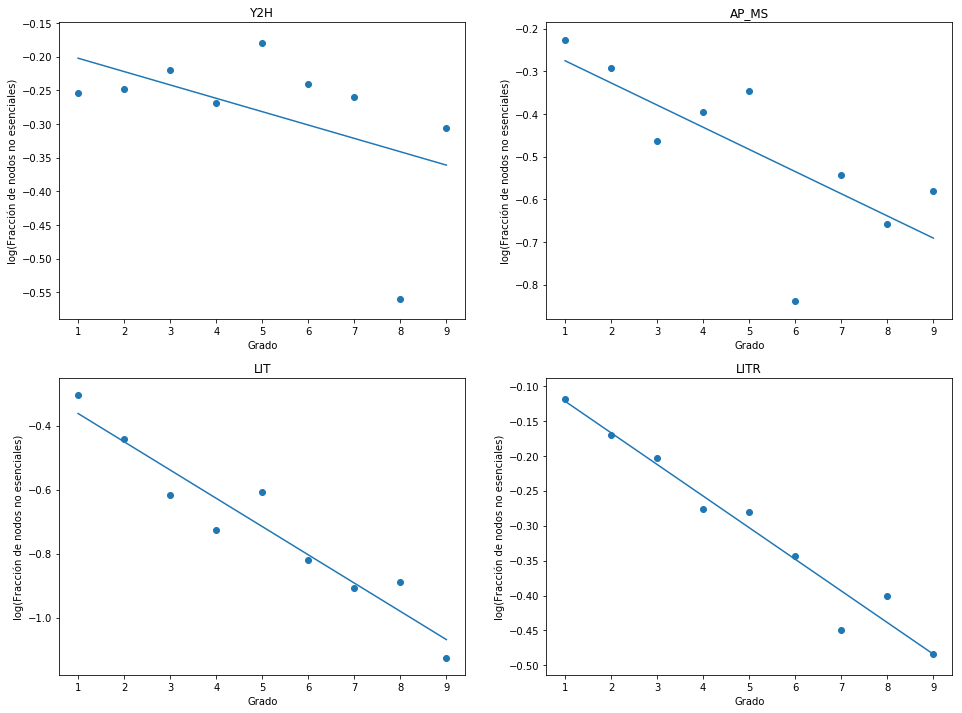

In [28]:
plt.rcParams['figure.figsize'] = (16,12)

def plot_degree(Net, esenciales):
    
    #Graficamos el scatter
    E_dict = essential_fraction_by_k(Net, esenciales)
    x = np.array(list(E_dict.keys()))
    y = np.log(np.array(list(E_dict.values())))
    
    #Graficamos el ajuste
    alfa,beta = alfa_beta(Net, esenciales)
    alfa = alfa.nominal_value
    beta = beta.nominal_value
    
    a = np.linspace(min(x),max(x),100)
    b = a*np.log(1-alfa)+np.log(1-beta)
    
    return x,y,a,b

plt.subplot(221)
x,y,a,b=plot_degree(Y2H,esenciales)    
plt.scatter(x,y)
plt.title("Y2H")
plt.xlabel("Grado")
plt.ylabel("log(Fracción de nodos no esenciales)")
plt.plot(a,b)

plt.subplot(222)
x,y,a,b=plot_degree(AP_MS,esenciales)    
plt.scatter(x,y)
plt.title("AP_MS")
plt.xlabel("Grado")
plt.ylabel("log(Fracción de nodos no esenciales)")
plt.plot(a,b)

plt.subplot(223)
x,y,a,b=plot_degree(LIT,esenciales)    
plt.scatter(x,y)
plt.title("LIT")
plt.xlabel("Grado")
plt.ylabel("log(Fracción de nodos no esenciales)")
plt.plot(a,b)

plt.subplot(224)
x,y,a,b=plot_degree(LITR,esenciales)    
plt.title("LITR")
plt.xlabel("Grado")
plt.ylabel("log(Fracción de nodos no esenciales)")
plt.scatter(x,y)
plt.plot(a,b)

#### Cálculo de alfa y beta por métodos de simulación

A parte de calcular alfa y beta ajustando los valores observados, se procedieron a hacer la sigientes simulaciones:

1) Para calcular alfa se simularon 10000 redes, partiendo de la red inicial. En cada una se recablearon 5000 aristas, manteniendo el grado de los nodos y se midió la cantidad de IBEPs (interacciones entre proteínas esenciales). Al igual que en He et al., en ningún caso la cantidad de IBEPs simulada fue superior a la de la red original. Por ello se tomo la hipótesis de que la diferencia corresponde a las interacciones esenciales de la red: 

\begin{equation*}
\alpha = IBEPs(org) - \mu(IBEPs(simulado)) / \#aristas
\end{equation*}

2) Por otro lado, para estimar beta, se simularon 1000 redes, partiendo de la red inicial. En cada una, se asignaron n interacciones esenciales (siguiendo la distribución obtenida de las simulaciones de alfa) y a partir de esas asignaciones se definieron los nodos esenciales (que contenian esas aristas). Luego, para alcanzar la cantidad de nodos esenciales original, se asigaba un nodo como esencial al azar ( de todos los nodos, no solo de los no esenciales ). Finalmente se define beta como la cantidad de nodos que tuvieron que agregarse para llegar de los nodos esenciales asignados a partir de las interacciones esenciales a la cantidad original.

\begin{equation*}
\beta = (nodos\_esenciales\_red\_org - nodos\_esenciales\_por\_inteaccion\_esencial) / \#nodos
\end{equation*}

In [29]:
def double_swap(Net):
    """Calcula la distribución de interacciones esenciales (IBEPs) en la red ingresada tras 10000
    iteraciones de cambio aleatorio de enlaces"""
    
    #Lleva cuenta de las interacciones esenciales reales en la red
    raw_m = 0
    for n1,n2 in Net.edges():
        if  Net.node[n1]["esencial"] and Net.node[n2]["esencial"]:
            raw_m += 1

    #Realiza 10000 simulaciones de recableado aleatorio de la red y computa
    #la cantidad de interacciones esenciales en cada una
    ms = []
    for _ in tqdm(range(10000)):
        G = Net.copy()
        G = nx.double_edge_swap(G,nswap=5000,max_tries=100000)
        m = 0
        for n1,n2 in G.edges():
            if  G.node[n1]["esencial"] and G.node[n2]["esencial"]:
                m += 1
        ms.append(m)
        
    return raw_m, ms, np.mean(ms), np.std(ms)

In [30]:
#Ejecutamos la función para las cuatro redes en cuestión
AP_MS_ds = double_swap(AP_MS_g)
Y2H_ds = double_swap(Y2H_g)
LIT_ds = double_swap(LIT_g)
LITR_ds = double_swap(LITR_g)

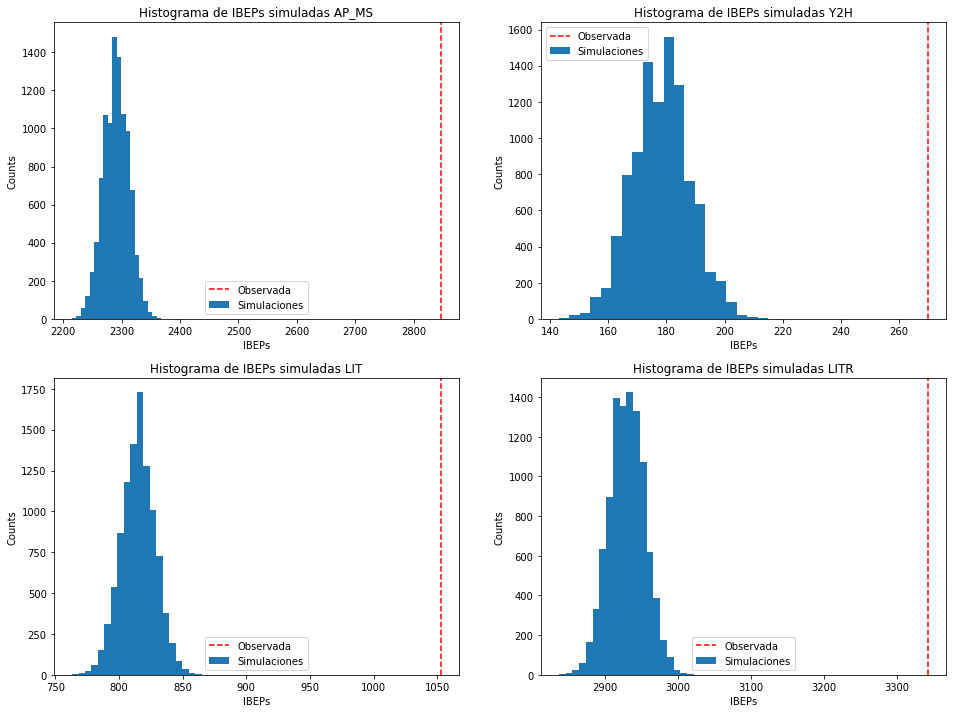

In [31]:
#Graficamos las IBEPs reales y simuladas
plt.rcParams['figure.figsize'] = (16,12)

plt.subplot(221)
plt.hist(AP_MS_ds[1],label="Simulaciones", bins=20)
plt.xlabel("IBEPs")
plt.ylabel("Counts")
plt.title("Histograma de IBEPs simuladas AP_MS")
plt.axvline(x=AP_MS_ds[0], color='red', linestyle='--',label="Observada")
plt.legend()

plt.subplot(222)
plt.hist(Y2H_ds[1],label="Simulaciones", bins=20)
plt.xlabel("IBEPs")
plt.ylabel("Counts")
plt.title("Histograma de IBEPs simuladas Y2H")
plt.axvline(x=Y2H_ds[0], color='red', linestyle='--',label="Observada")
plt.legend()

plt.subplot(223)
plt.hist(LIT_ds[1],label="Simulaciones", bins=20)
plt.xlabel("IBEPs")
plt.ylabel("Counts")
plt.title("Histograma de IBEPs simuladas LIT")
plt.axvline(x=LIT_ds[0], color='red', linestyle='--',label="Observada")
plt.legend()

plt.subplot(224)
plt.hist(LITR_ds[1],label="Simulaciones", bins=20)
plt.xlabel("IBEPs")
plt.ylabel("Counts")
plt.title("Histograma de IBEPs simuladas LITR")
plt.axvline(x=LITR_ds[0], color='red', linestyle='--',label="Observada")
plt.legend()

plt.show()

Se observa en la figura superior la distribución de IBEPs obtenidas a partir de 10000 simulaciones para cada red. En concordancia con He et al. como en ningún caso la probabilidad de que el valor real de IBEPs (línea vertical roja) provenga de la distribución simulada es alta, se asume que la diferencia corresponde a las interacciones esenciales en la red.

In [32]:
#Calculamos beta teniendo en cuenta lo descripto arriba
def b_calculation(Net, raw_m, ms):
    """Devuelve un valor estimado de beta (la probabilidad de que una proteína sea esencial por factores distintos a su
    interacción con otras proteínas, como interacciones con ADN, etc.) y el desvío estandar asociado."""
    
    #Número de nodos esenciales en la red
    n_esenciales = len([x for x,data in Net.nodes(data=True) if data["esencial"] ])
    
    bs = []
    overlaps = []
    e_por_pii   = []
    for _ in tqdm(range(1000)):
        G = Net.copy()
        
        # Cantidad de interacciones esenciales
        m =  random.choice(ms)
        EPII = raw_m - m
        
        # Asignamos edges esenciales al azar y marcar nodos esenciales por estar en EPII
        nodos_esenciales = []
        for n1,n2 in random.sample(G.edges(),EPII):
            nodos_esenciales.append(n1)
            nodos_esenciales.append(n2)
        nodos_esenciales = set(nodos_esenciales)
    
        # Agregamos nodos esenciales al azar hasta completar
        try:
            faltantes = n_esenciales - len(nodos_esenciales)
            e_por_pii.append(len(nodos_esenciales) )
            #print(len(G.nodes()), faltantes)
            overlap = len(set(random.sample(G.nodes(), faltantes ) ) and nodos_esenciales)
            overlaps.append(overlap)
            agregados = set(random.sample(G.nodes(), faltantes ) ) - nodos_esenciales
            bs.append(len(agregados))
    
        except ValueError:
            continue
    
    mean_b = np.mean(bs)
    std_b = np.std(bs)
    mean_o = np.mean(overlaps)
    std_o = np.std(overlaps)
    mean_pii = np.mean(e_por_pii)
    std_pii = np.std(e_por_pii)
    
    return ufloat(mean_b, std_b), bs

In [33]:
#Guardamos los coeficientes b, que nos van a permitir calcular los beta
b_AP_MS, bs_AP_MS = b_calculation(AP_MS_g, AP_MS_ds[0], AP_MS_ds[1])
b_Y2H, bs_Y2H = b_calculation(Y2H_g, Y2H_ds[0], Y2H_ds[1])
b_LIT, bs_LIT = b_calculation(LIT_g, LIT_ds[0], LIT_ds[1])
b_LITR, bs_LITR = b_calculation(LITR_g, LITR_ds[0], LITR_ds[1])

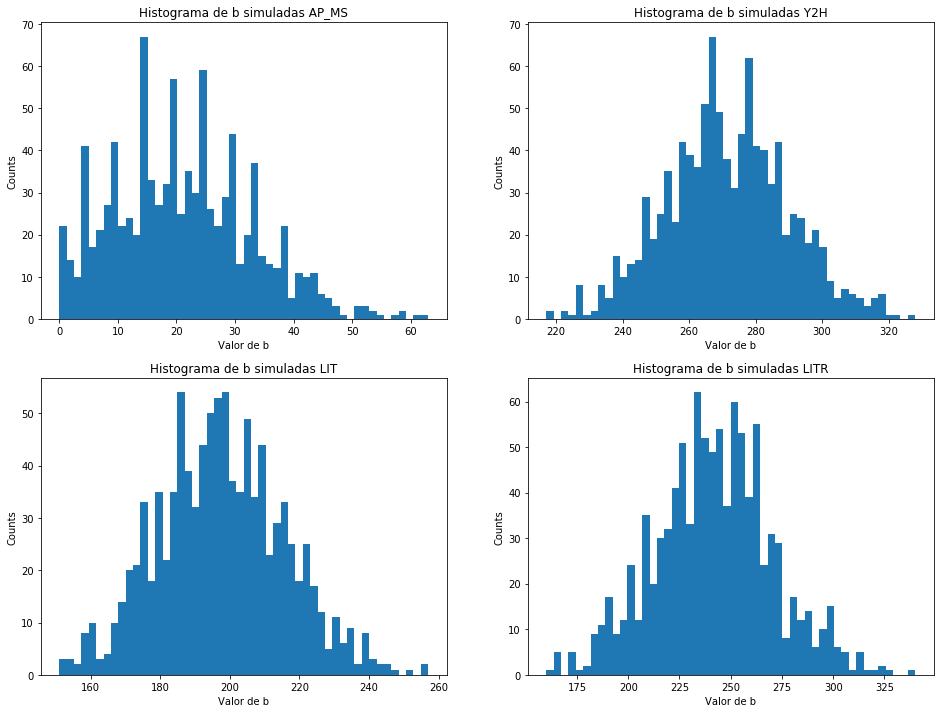

In [34]:
plt.rcParams['figure.figsize'] = (16,12)

plt.subplot(221)
plt.hist(bs_AP_MS, bins=50)
plt.xlabel("Valor de b")
plt.ylabel("Counts")
plt.title("Histograma de b simuladas AP_MS")

plt.subplot(222)
plt.hist(bs_Y2H, bins=50)
plt.xlabel("Valor de b")
plt.ylabel("Counts")
plt.title("Histograma de b simuladas Y2H")

plt.subplot(223)
plt.hist(bs_LIT, bins=50)
plt.xlabel("Valor de b")
plt.ylabel("Counts")
plt.title("Histograma de b simuladas LIT")

plt.subplot(224)
plt.hist(bs_LITR, bins=50)
plt.xlabel("Valor de b")
plt.ylabel("Counts")
plt.title("Histograma de b simuladas LITR")

plt.show()

Se observa en la figura de arriba la distribución en la cantidad de nodos esenciales estimados que no dependen de los enlaces esenciales (definida como b, que no es lo mismo que beta).

En la siguiente tabla pueden compararse los valores de alfa y beta obtenidos por ambos métodos:

In [52]:
alfa_beta_df = pd.DataFrame({'AP_MS':[*alfa_beta(AP_MS, esenciales), *alfa_beta_sim(AP_MS, AP_MS_ds[0], ufloat(AP_MS_ds[2],AP_MS_ds[3]), b_AP_MS)],
                             'Y2H':[*alfa_beta(Y2H, esenciales), *alfa_beta_sim(Y2H, Y2H_ds[0], ufloat(Y2H_ds[2],Y2H_ds[3]), b_Y2H)],
                             'LIT':[*alfa_beta(LIT, esenciales), *alfa_beta_sim(LIT, LIT_ds[0], ufloat(LIT_ds[2],LIT_ds[3]), b_LIT)],
                             'LITR':[*alfa_beta(LITR, esenciales), *alfa_beta_sim(LITR, LITR_ds[0], ufloat(LITR_ds[2],LITR_ds[3]), b_LITR)]}).T
alfa_beta_df.columns = ['Alfa (ajuste lineal)','Beta (ajuste lineal)','Alfa (simulación)','Beta (simulación)']
alfa_beta_df

,Alfa (ajuste lineal),Beta (ajuste lineal),Alfa (simulación),Beta (simulación)
AP_MS,0.051+/-0.017,0.200+/-0.018,0.0613+/-0.0024,0.013+/-0.007
Y2H,0.020+/-0.013,0.167+/-0.015,0.0101+/-0.0011,0.134+/-0.009
LIT,0.084+/-0.009,0.239+/-0.021,0.0262+/-0.0015,0.129+/-0.012
LITR,0.0443+/-0.0035,0.074+/-0.007,0.0455+/-0.0027,0.073+/-0.009


De esta tabla pueden concluirse dos cosas: los valores para los coeficientes obtenidos por ambos métodos son comparables, y los valores de beta tienden a ser más grandes que los de alfa. Esto último (que se cumple en todos los casos salvo en las simulaciones de AP_MS, excluidas del análisis como fue mencionado más arriba) remite a que la probabilidad de que una proteína sea esencial por razones no relacionadas con la participación en una interacción esencial suelen ser mayores.

#### Comparación de pares del mismo tipo reales versus predichos por los modelos

Como se mencionó antes, estos modelos asumen que la probabilidad de dos proteínas no conectadas de ser esenciales es disjunta. La probabilidad de que un par de proteínas sean esenciales, entonces, puede calcularse como la probabilidad de una de ser esencial por la probabilidad de la otra.

\begin{equation*}
Pe_i,_j = Pe_i . Pe_j
\end{equation*}

donde Pei es la probabilidad de que la proteína i sea esencial, Pej es la probabilidad de que la proteína j sea esencial y Pei,j es la probabilidad de esencialidad conjunta del par i,j.

Como también se mencionó, según Zotenko et al. la esencialidad es un fenómeno que tiene lugar a otra escala: las proteínas esenciales son aquellas necesarias para el funcionamiento de complejos esenciales. Según este razonamiento, dos proteínas que pertenezcan al mismo complejo deberían tener mayor probabilidad de ser esenciales independientemente de si están conectadas o no.

Teniendo esto en mente, se estudió el poder predictivo de los modelos propuestos por He para pares de proteínas no conectados que compartieran tres o más vecinos.

Se contaron los pares de nodos totales que cumplieran con esta condición en las cuatro redes bajo estudio, y se delimitó cuántos de ellos están compuestos por proteínas del mismo tipo (ambas esenciales o no esenciales). Luego, se calculó la probabilidad de esencialidad o no esencialidad de cada par utilizando los alfa y beta provenientes de cada uno de los enfoques descriptos más arriba. A partir de estas probabilidades se estimó el número de pares del mismo tipo esperados para cada red según ambas variantes del modelo de He, como la sumatoria de probabilidades de todos los pares de la red de estar compuestos por dos proteínas esenciales o dos proteínas no esenciales.

Sea n la cantidad de pares en la red que cumplen con las condiciones estipuladas, la cantidad de pares esperados se calcula como

\begin{equation*}
Pares\_esperados = \sum_{i=1}^n Pe_i + Pne_i
\end{equation*}

donde Pei es la probabilidad del par i de contener dos proteínas esenciales, y Pnei es la probabilidad del par i de contener dos proteínas no esenciales.

Las incertezas reportadas surgen de la propagación de los errores propios de los alfa y beta utilizados en cada caso. Para la regresión lineal, los mismos surgen a partir de la pendiente y ordenada al origen estimados; para las simulaciones, a partir del desvío estándar de las distribuciones obtenidas (la normalidad fue testeada mediante la prueba de Shapiro-Wilks). Los resultados se muestran en la siguiente tabla.

In [379]:
#Procedemos a calcular el número total de pares de nodos que comparten 3 o más vecinos
def N_pairs(Net, cutoff=3, same_type=False, esenciales=esenciales):
    """Devuelve la cantidad de nodos de la red que tienen 3 o más vecinos en común. Si same_type == True,
    sólo tiene en cuenta nodos del mismo tipo (esenciales o no esenciales)"""

    Degree_dist = dict(nx.degree(Net))
    
    #Generamos un diccionario con los grados como claves y los nombres de los nodos como valores. 
    Node_list = []
    for k,v in Degree_dist.items():
        if v >= cutoff:
            Node_list.append(k)

            
    Pairs = []
    
    #Chequea qué pares de proteínas comparten 3 o más vecinos. Si same_type == True, chequea esa condición.
    for i in itertools.combinations(Node_list, 2):
        if i[0] not in Net.neighbors(i[1]):
            if len(np.intersect1d(list(Net.neighbors(i[0])),list(Net.neighbors(i[1])))) >= cutoff:
                if same_type == True and ((i[0] in esenciales and i[1] in esenciales) or \
                                      (i[0] not in esenciales and i[1] not in esenciales)):
                    Pairs.append(i)
                
                elif same_type == False:
                    Pairs.append(i)
        
    return Pairs

In [380]:
def Prob_esencial(alfa, beta, k):
    """Devuelve la probabilidad de que un dado nodo sea esencial"""
    return 1-(((1-alfa)**k)*(1-beta))

def Pares_predichos(Net, cutoff=3, esenciales=esenciales, sim=False, raw_m=None, m=None, b=None):
    """Devuelve el número de pares de nodos no conectados, con 3 vecinos o más y del mismo tipo esperados
    según el alfa y beta especificados"""
    
    if sim == False:
        alfa, beta = alfa_beta(Net, esenciales)
    elif sim == True:
        alfa, beta = alfa_beta_sim(Net, raw_m, m, b)
    
    #Guarda primero en una lista los pares totales de nodos que cumplen las características en la red ingresada
    Pair_list = N_pairs(Net, cutoff=cutoff, esenciales=esenciales, same_type=False)
    
    Same_type_prob = []
    #Itera sobre la lista de pares, calcula y almacena la probabilidad de pares del mismo tipo
    for i in Pair_list:
        Prob_E = Prob_esencial(alfa, beta, Net.degree(i[0]))*Prob_esencial(alfa, beta, Net.degree(i[1]))
        Prob_NE = (1 - Prob_esencial(alfa, beta, Net.degree(i[0])))*(1 - Prob_esencial(alfa, beta, Net.degree(i[1])))
        Same_type_prob.append(Prob_E + Prob_NE)
    
    return sum(Same_type_prob)

In [381]:
#Calculamos número total de pares para cada red
Pares_AP_MS = len(N_pairs(AP_MS))
Pares_Y2H =  len(N_pairs(Y2H, cutoff=1))
Pares_LIT =  len(N_pairs(LIT))
Pares_LITR = len(N_pairs(LITR))

In [382]:
#Calculamos número de pares del mismo tipo para cada red
Pares_st_AP_MS = len(N_pairs(AP_MS, same_type=True))
Pares_st_Y2H = len(N_pairs(Y2H, cutoff=1, same_type=True))
Pares_st_LIT = len(N_pairs(LIT, same_type=True))
Pares_st_LITR = len(N_pairs(LITR, same_type=True))

In [383]:
#Calculamos número de pares predichos por regresión lineal, con su error asociado
Pares_pred_lr_AP_MS = Pares_predichos(AP_MS)
Pares_pred_lr_Y2H = Pares_predichos(Y2H, cutoff=1)
Pares_pred_lr_LIT = Pares_predichos(LIT)
Pares_pred_lr_LITR = Pares_predichos(LITR)

In [387]:
#Calculamos número de pares predichos por simulación, con su error asociado
Pares_pred_sim_AP_MS = Pares_predichos(AP_MS, sim=True, raw_m=AP_MS_ds[0], m=ufloat(AP_MS_ds[2],AP_MS_ds[3]), b=b_AP_MS)
Pares_pred_sim_Y2H = Pares_predichos(Y2H, cutoff=1, sim=True, raw_m=Y2H_ds[0], m=ufloat(Y2H_ds[2],Y2H_ds[3]), b=b_Y2H)
Pares_pred_sim_LIT = Pares_predichos(LIT, sim=True, raw_m=LIT_ds[0], m=ufloat(LIT_ds[2],LIT_ds[3]), b=b_LIT)
Pares_pred_sim_LITR = Pares_predichos(LITR, sim=True, raw_m=LITR_ds[0], m=ufloat(LITR_ds[2],LITR_ds[3]), b=b_LITR)

In [395]:
Expected_pairs_table = pd.DataFrame({'Número total de pares':[Pares_AP_MS, Pares_Y2H, Pares_LIT, Pares_LITR],
               'Número de pares del mismo tipo':[Pares_st_AP_MS, Pares_st_Y2H, Pares_st_LIT, Pares_st_LITR],
               'Simulación':[str(int(Pares_pred_sim_AP_MS.nominal_value))+'+/-'+str(int(Pares_pred_sim_AP_MS.std_dev)),
                str(int(Pares_pred_sim_Y2H.nominal_value))+'+/-'+str(int(Pares_pred_sim_Y2H.std_dev)),
                str(int(Pares_pred_sim_LIT.nominal_value))+'+/-'+str(int(Pares_pred_sim_LIT.std_dev)),
                str(int(Pares_pred_sim_LITR.nominal_value))+'+/-'+str(int(Pares_pred_sim_LITR.std_dev)),],
               'Ajuste lineal':[str(int(Pares_pred_lr_AP_MS.nominal_value))+'+/-'+str(int(Pares_pred_lr_AP_MS.std_dev)),
                str(int(Pares_pred_lr_Y2H.nominal_value))+'+/-'+str(int(Pares_pred_lr_Y2H.std_dev)),
                str(int(Pares_pred_lr_LIT.nominal_value))+'+/-'+str(int(Pares_pred_lr_LIT.std_dev)),
                str(int(Pares_pred_lr_LITR.nominal_value))+'+/-'+str(int(Pares_pred_lr_LITR.std_dev)),],
               'P-valor simulación':[stats.norm.sf(np.abs(Pares_st_AP_MS-Pares_pred_sim_AP_MS.nominal_value)/Pares_pred_sim_AP_MS.std_dev),
                                        stats.norm.sf(np.abs(Pares_st_Y2H-Pares_pred_sim_Y2H.nominal_value)/Pares_pred_sim_Y2H.std_dev),
                                        stats.norm.sf(np.abs(Pares_st_LIT-Pares_pred_sim_LIT.nominal_value)/Pares_pred_sim_LIT.std_dev),
                                        stats.norm.sf(np.abs(Pares_st_LITR-Pares_pred_sim_LITR.nominal_value)/Pares_pred_sim_LITR.std_dev)],
               'P-valor ajuste lineal':[stats.norm.sf(np.abs(Pares_st_AP_MS-Pares_pred_lr_AP_MS.nominal_value)/Pares_pred_lr_AP_MS.std_dev),
                                        stats.norm.sf(np.abs(Pares_st_Y2H-Pares_pred_lr_Y2H.nominal_value)/Pares_pred_lr_Y2H.std_dev),
                                        stats.norm.sf(np.abs(Pares_st_LIT-Pares_pred_lr_LIT.nominal_value)/Pares_pred_lr_LIT.std_dev),
                                        stats.norm.sf(np.abs(Pares_st_LITR-Pares_pred_lr_LITR.nominal_value)/Pares_pred_lr_LITR.std_dev)]})

In [396]:
np.set_printoptions(floatmode='unique')
Expected_pairs_table.index = ['AP_MS','Y2H','LIT','LITR']
Expected_pairs_table

,Número total de pares,Número de pares del mismo tipo,Simulación,Ajuste lineal,P-valor simulación,P-valor ajuste lineal
AP_MS,11613,5907,7722+/-125,7772+/-954,6.454696e-48,2.533794e-02
Y2H,23073,15087,15904+/-279,14075+/-1192,1.730440e-03,1.981463e-01
LIT,730,389,413+/-6,399+/-12,1.141190e-04,1.917992e-01
LITR,10777,6187,5657+/-56,5633+/-69,7.530339e-21,7.637835e-16


Como puede observarse, en todos los casos (si bien AP_MS no debe ser tenido en cuenta para el análisis por los motivos explicados más arriba) alguno de los dos métodos reporta diferencias significativas entre los números esperado y real de pares del mismo tipo en cada red.

Esto prueba que, al menos en estas redes, la probabilidad de dos proteínas no conectadas de ser esenciales <b>no es disjunta</b>, sino que depende en principio de su cercania en la red. Para indagar en esto más exhaustivamente, podría repetirse el análisis utilizando todos aquellos pares de proteínas no conectadas que no pertenezcan al mismo complejo biológico (utilizando anotación ontológica, por ejemplo) independientemente de su conectividad en una red en particular. Si la hipótesis de Zotenko et al. es cierta, el modelo de He debería aplicar. 

### Bibliografía

<li>He, Xionglei, and Jianzhi Zhang. 2006. “Why Do Hubs Tend to Be Essential in Protein Networks?” PLoS Genetics 2 (6): e88.
<li>Jeong, H., S. P. Mason, A. L. Barabási, and Z. N. Oltvai. 2001. “Lethality and Centrality in Protein Networks.” Nature 411 (6833): 41–42.
<li>Zotenko, Elena, Julian Mestre, Dianne P. O’Leary, and Teresa M. Przytycka. 2008. “Why Do Hubs in the Yeast Protein Interaction Network Tend to Be Essential: Reexamining the Connection between the Network Topology and Essentiality.” PLoS Computational Biology 4 (8): e1000140.